# Task 5: damped pendulum
Christine Allen-Blanchette (adapted from Sam Greydanus, Task 2: ideal pendulum)

In [1]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-damped-pend'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, get_field, get_trajectory, dynamics_fn, hamiltonian_fn
from lag_data import get_lag_dataset, get_lag_field, get_lag_trajectory, lag_dynamics_fn, lagrangian_fn, lag_energy_fn

from nn_models import MLP
from hnn import HNN
from symoden import SymODEN_R
from lagnet import Lagrangian

from utils import L2_loss

## Set some notebook constants

In [2]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'pend',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Inspect the dataset

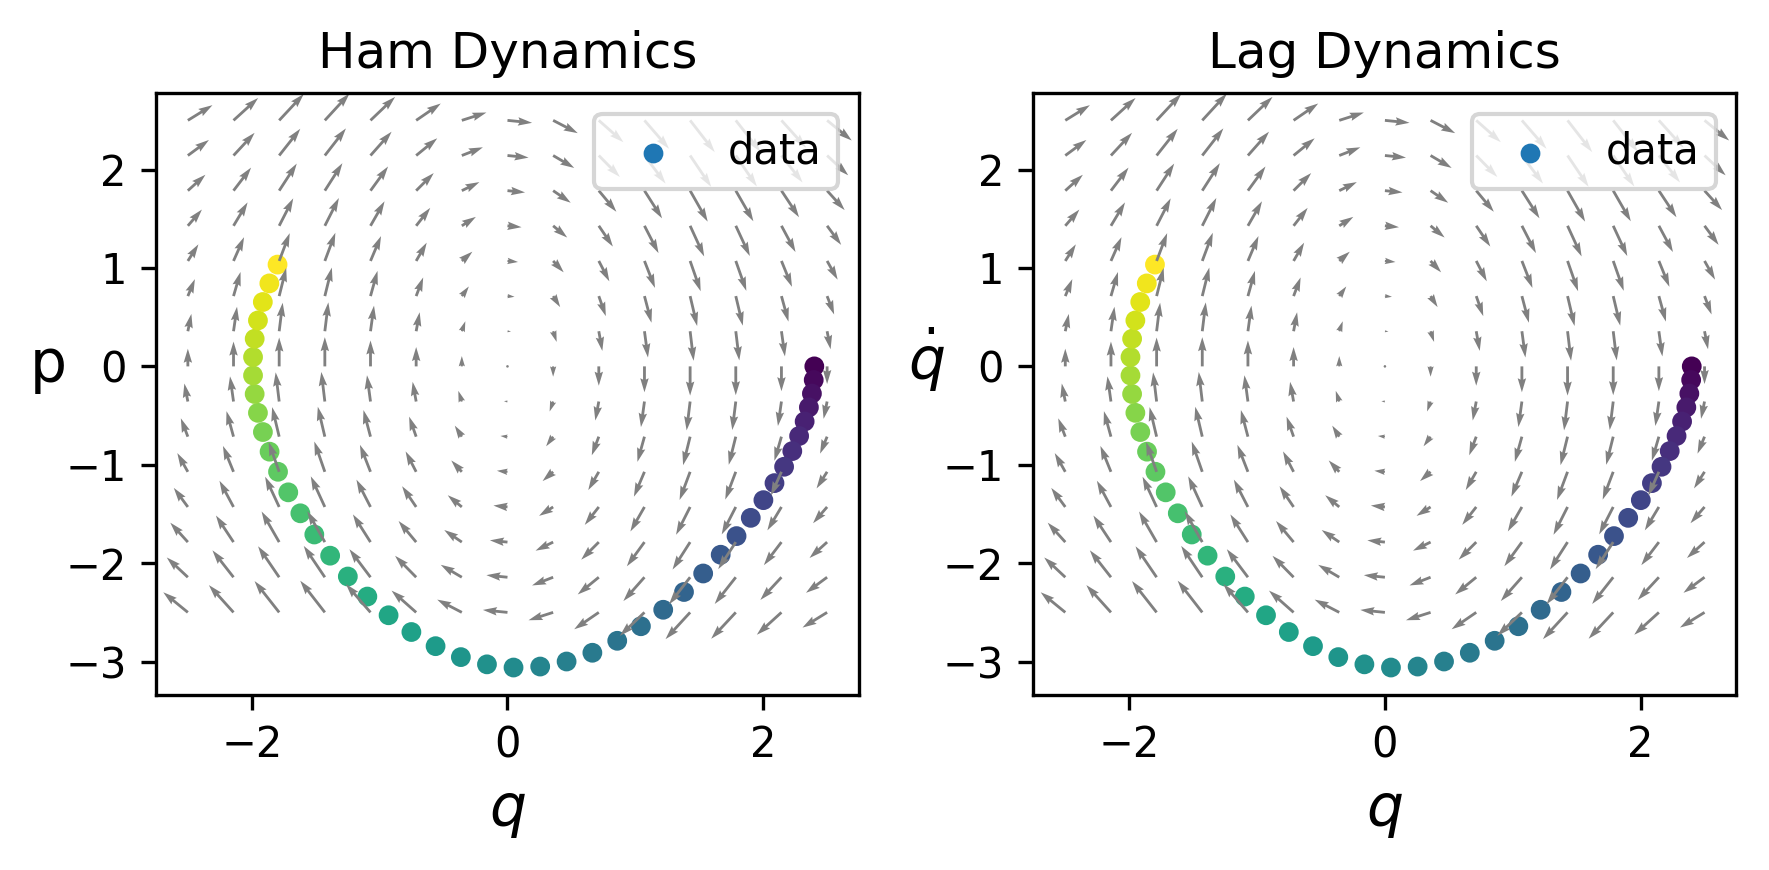

In [3]:
args = ObjectView(get_args())
np.random.seed(args.seed)
R = 2.5

# plot config
fig = plt.figure(figsize=(6, 3), facecolor='white', dpi=DPI)

# ham data
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=15)
data_ham = get_dataset()
x_ham, y_ham, dx_ham, dy_ham, t_ham = get_trajectory(radius=2.4, y0=np.array([2,0]), noise_std=0)

fig.add_subplot(1, 2, 1, frameon=True)
plt.scatter(x_ham, y_ham,c=t_ham, s=14, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("p", rotation=0, fontsize=14)
plt.title("Ham Dynamics")
plt.legend(loc='upper right')

# lag data
lag_field = get_lag_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=15)
data_lag = get_lag_dataset()
x_lag, y_lag, dx_lag, dy_lag, t_lag = get_lag_trajectory(radius=2.4, y0=np.array([2,0]), noise_std=0)

fig.add_subplot(1, 2, 2, frameon=True)
plt.scatter(x_lag, y_lag, c=t_lag, s=14, label='data')
plt.quiver(lag_field['x'][:,0], lag_field['x'][:,1], lag_field['dx'][:,0], lag_field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$\dot{q}$", rotation=0, fontsize=14)
plt.title("Lag Dynamics")
plt.legend(loc='upper right')

plt.tight_layout() ; plt.show()
# fig.savefig(fig_dir + '/spring-task.png')

## Construct models

In [4]:
def get_HNN_model(args, name):
    baseline=True if name in ['baseline'] else False
    output_dim = args.input_dim if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type, baseline=baseline)
    return model

def get_SymODEN_model(args, name=None):
    M_net = MLP(int(args.input_dim/2), 300, int(args.input_dim/2))
    V_net = MLP(int(args.input_dim/2), 50, 1)
    g_net = MLP(int(args.input_dim/2), 200, int(args.input_dim/2))
    model = SymODEN_R(args.input_dim, M_net=M_net, V_net=V_net, g_net=g_net, device=None, baseline=False, structure=True)

    return model

def get_Lagrangian_model(args, name=None):
    S_net = MLP(int(args.input_dim/2), 140, int(args.input_dim/2)**2, args.nonlinearity)
    U_net = MLP(int(args.input_dim/2), 140, 1, args.nonlinearity)
    model = Lagrangian(int(args.input_dim/2), S_net, U_net, dt=1e-3)
    
    return model

def get_model(args, name):
    if name in ['hnn', 'baseline']:
        model = get_HNN_model(args, name)
    elif name in ['lag']:
        model = get_Lagrangian_model(args, name=None)
    else:
        model = get_SymODEN_model(args, name=None)
    
    # model_name = 'baseline' if baseline else 'hnn'
    path = "{}/pend{}-{}.tar".format(args.save_dir, RK4, name)
    model.load_state_dict(torch.load(path))
    return model

## Get vector fields

In [5]:
def get_vector_field(model, field):
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor( np_mesh_x, requires_grad=True, dtype=torch.float32)
    
    if isinstance(model, HNN):
        mesh_dx = model.time_derivative(mesh_x)
    else:
        # append zero control
        u = torch.zeros_like(mesh_x[:,0]).unsqueeze(-1)
        mesh_x = torch.cat((mesh_x, u), -1)
        
        dx, dy, du = model.time_derivative(mesh_x).split(1,1)
        mesh_dx = torch.cat((dx, dy), -1)
        
    return mesh_dx.data.numpy()

## Integrate along vector fields

In [6]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        if isinstance(model, Lagrangian):
            x = torch.tensor( np_x, requires_grad=False, dtype=torch.float32).view(1,2)
        else:
            x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
            
        if isinstance(model, HNN):
            dx = model.time_derivative(x).data.numpy().reshape(-1)
        else:
            # append zero control
            u = torch.zeros_like(x[:,0]).unsqueeze(-1)
            x = torch.cat((x, u), -1)
        
            dx, dy, du = model.time_derivative(x).split(1,1)
            dx = torch.cat((dx, dy), -1).data.numpy().reshape(-1)
            
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

## Run analysis

In [7]:
sym_model = get_model(args, name='sym')
hnn_model = get_model(args, name='hnn')
lag_model = get_model(args, name='hnn')

# get their vector fields
R = 2.6
# ham
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)
data = get_dataset(radius=2.0)
sym_field = get_vector_field(sym_model, field)
hnn_field = get_vector_field(hnn_model, field)
# lag
lag_field = get_lag_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)
lag_data = get_lag_dataset(radius=2.0)
lag_field_est = get_vector_field(lag_model, lag_field)

# integrate along those fields starting from point (1,0)
t_span = [0,28]
y0 = np.asarray([2.1, 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}
sym_ivp = integrate_model(sym_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(hnn_model, t_span, y0, **kwargs)
lag_ivp = integrate_model(lag_model, t_span, y0, **kwargs)

## Plot results

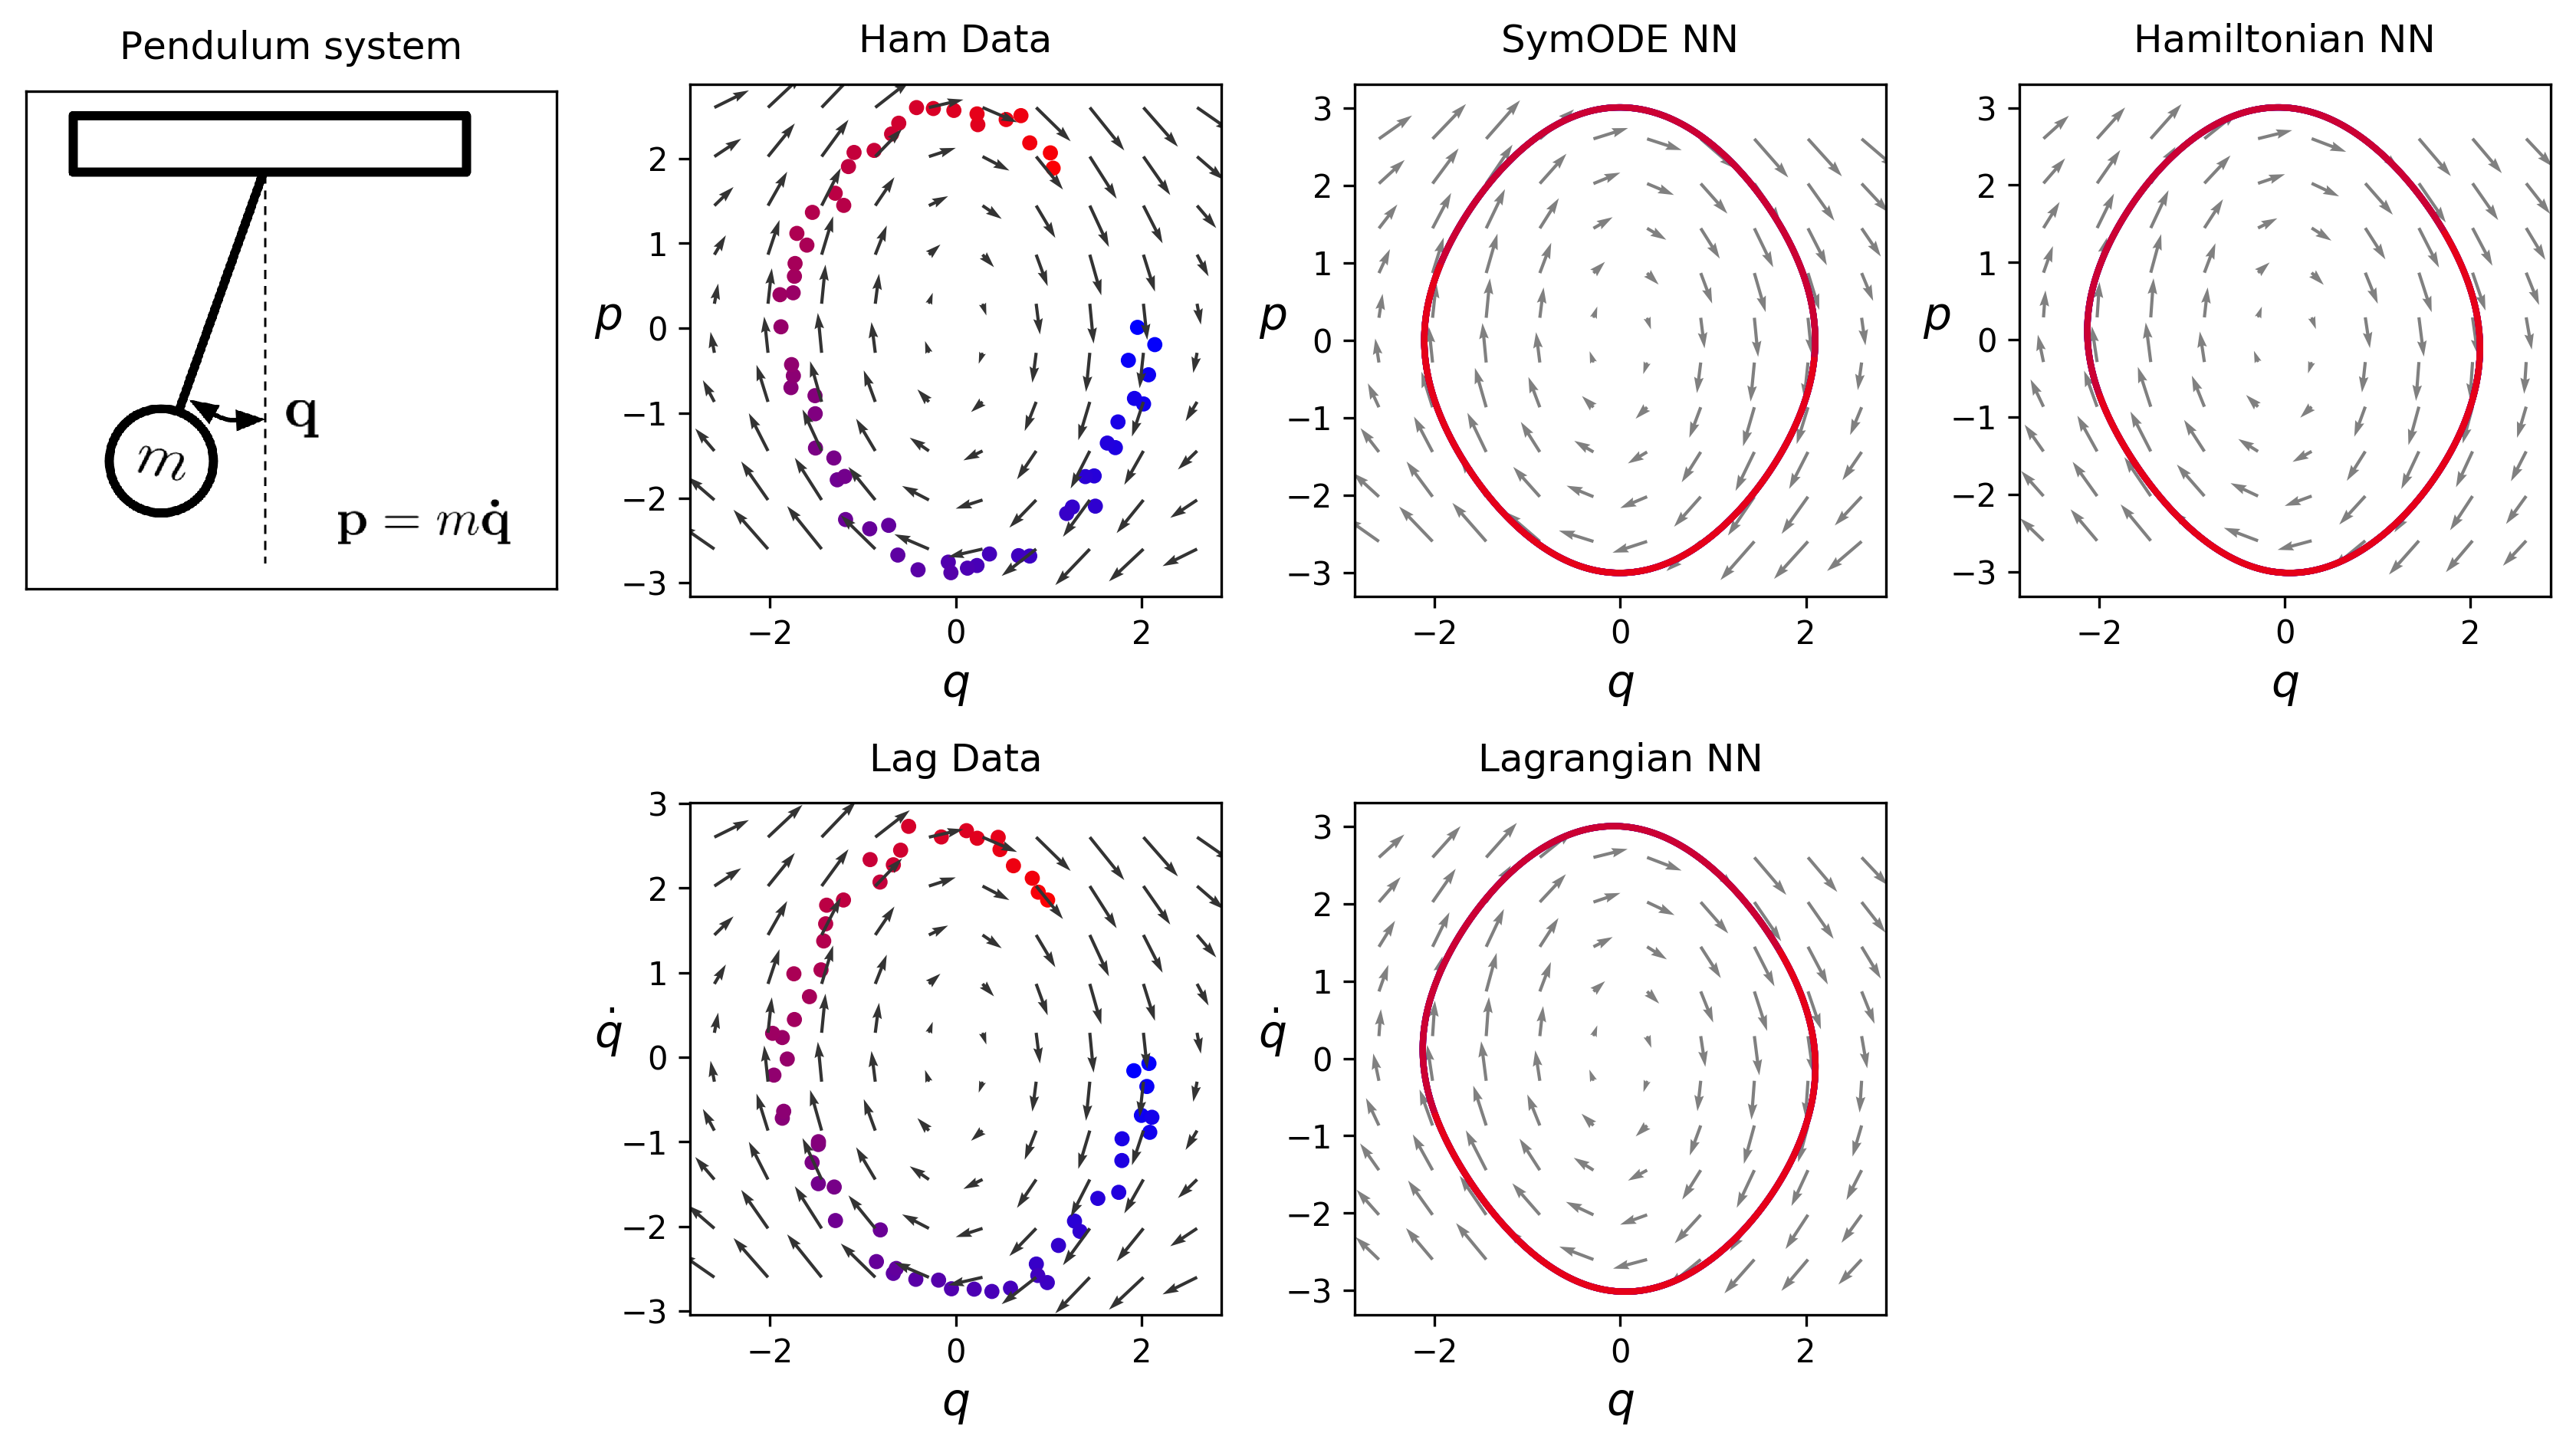

In [8]:
###### PLOT ######
fig = plt.figure(figsize=(11.3, 6.4), facecolor='white', dpi=DPI)

# plot physical system
fig.add_subplot(2, 4, 1, frameon=True) 
plt.xticks([]) ;  plt.yticks([])
schema = mpimg.imread(EXPERIMENT_DIR + '/pendulum.png')
plt.imshow(schema)
plt.title("Pendulum system", pad=10)

# plot ham dynamics
fig.add_subplot(2, 4, 2, frameon=True)
x, y, dx, dy, t = get_trajectory(t_span=[0,4], radius=2.1, y0=y0)
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x,y, s=14, label='data', c=point_colors)

plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.2,.2,.2))  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Ham Data", pad=10)

# plot symode
fig.add_subplot(2, 4, 3, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], sym_field[:,0], sym_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(sym_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("SymODE NN", pad=10)

# plot HNN
fig.add_subplot(2, 4, 4, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)

# plot lag dynamics
fig.add_subplot(2, 4, 6, frameon=True)
x_lag, y_lag, dx_lag, dy_lag, t_lag = get_lag_trajectory(t_span=[0,4], radius=2.1, y0=y0)
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x_lag, y_lag, s=14, label='data', c=point_colors)

plt.quiver(lag_field['x'][:,0], lag_field['x'][:,1], lag_field['dx'][:,0], lag_field['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.2,.2,.2))  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$\dot{q}$", rotation=0, fontsize=14)
plt.title("Lag Data", pad=10)

# plot Lag
fig.add_subplot(2, 4, 7, frameon=True)
plt.quiver(lag_field['x'][:,0], lag_field['x'][:,1], lag_field_est[:,0], lag_field_est[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(lag_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$\dot{q}$", rotation=0, fontsize=14)
plt.title("Lagrangian NN", pad=10)

plt.tight_layout() ; plt.show()
fig.savefig('{}/pend{}.{}'.format(args.fig_dir, RK4, FORMAT))

## Quantitative analysis
* Choose trajectories from the test set
* Measure vector field loss at each point
* Integrate along trajectory and measure mean loss between points

In [9]:
def integrate_models(model, x0=np.asarray([1, 0]), t_span=[0,5], t_eval=None):
    if isinstance(model, Lagrangian):
        fcn = lag_dynamics_fn
    else:
        fcn = dynamics_fn
        
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = solve_ivp(fun=fcn, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T

    # integrate along vector field
    model_path = integrate_model(model, t_span, x0, **kwargs)
    model_x = model_path['y'].T
    # _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)
    
    return true_x, model_x

def vector_field_loss(x, dx_hat):
    dx = circular_vector_field(t=None, x=x)
    return np.mean((dx - dx_hat)**2)

def energy_loss(true_x, integrated_x):
    true_energy = (true_x**2).sum(1)
    integration_energy = (integrated_x**2).sum(1)
    return np.mean((true_energy - integration_energy)**2)

AttributeError: 'tuple' object has no attribute 'detach'

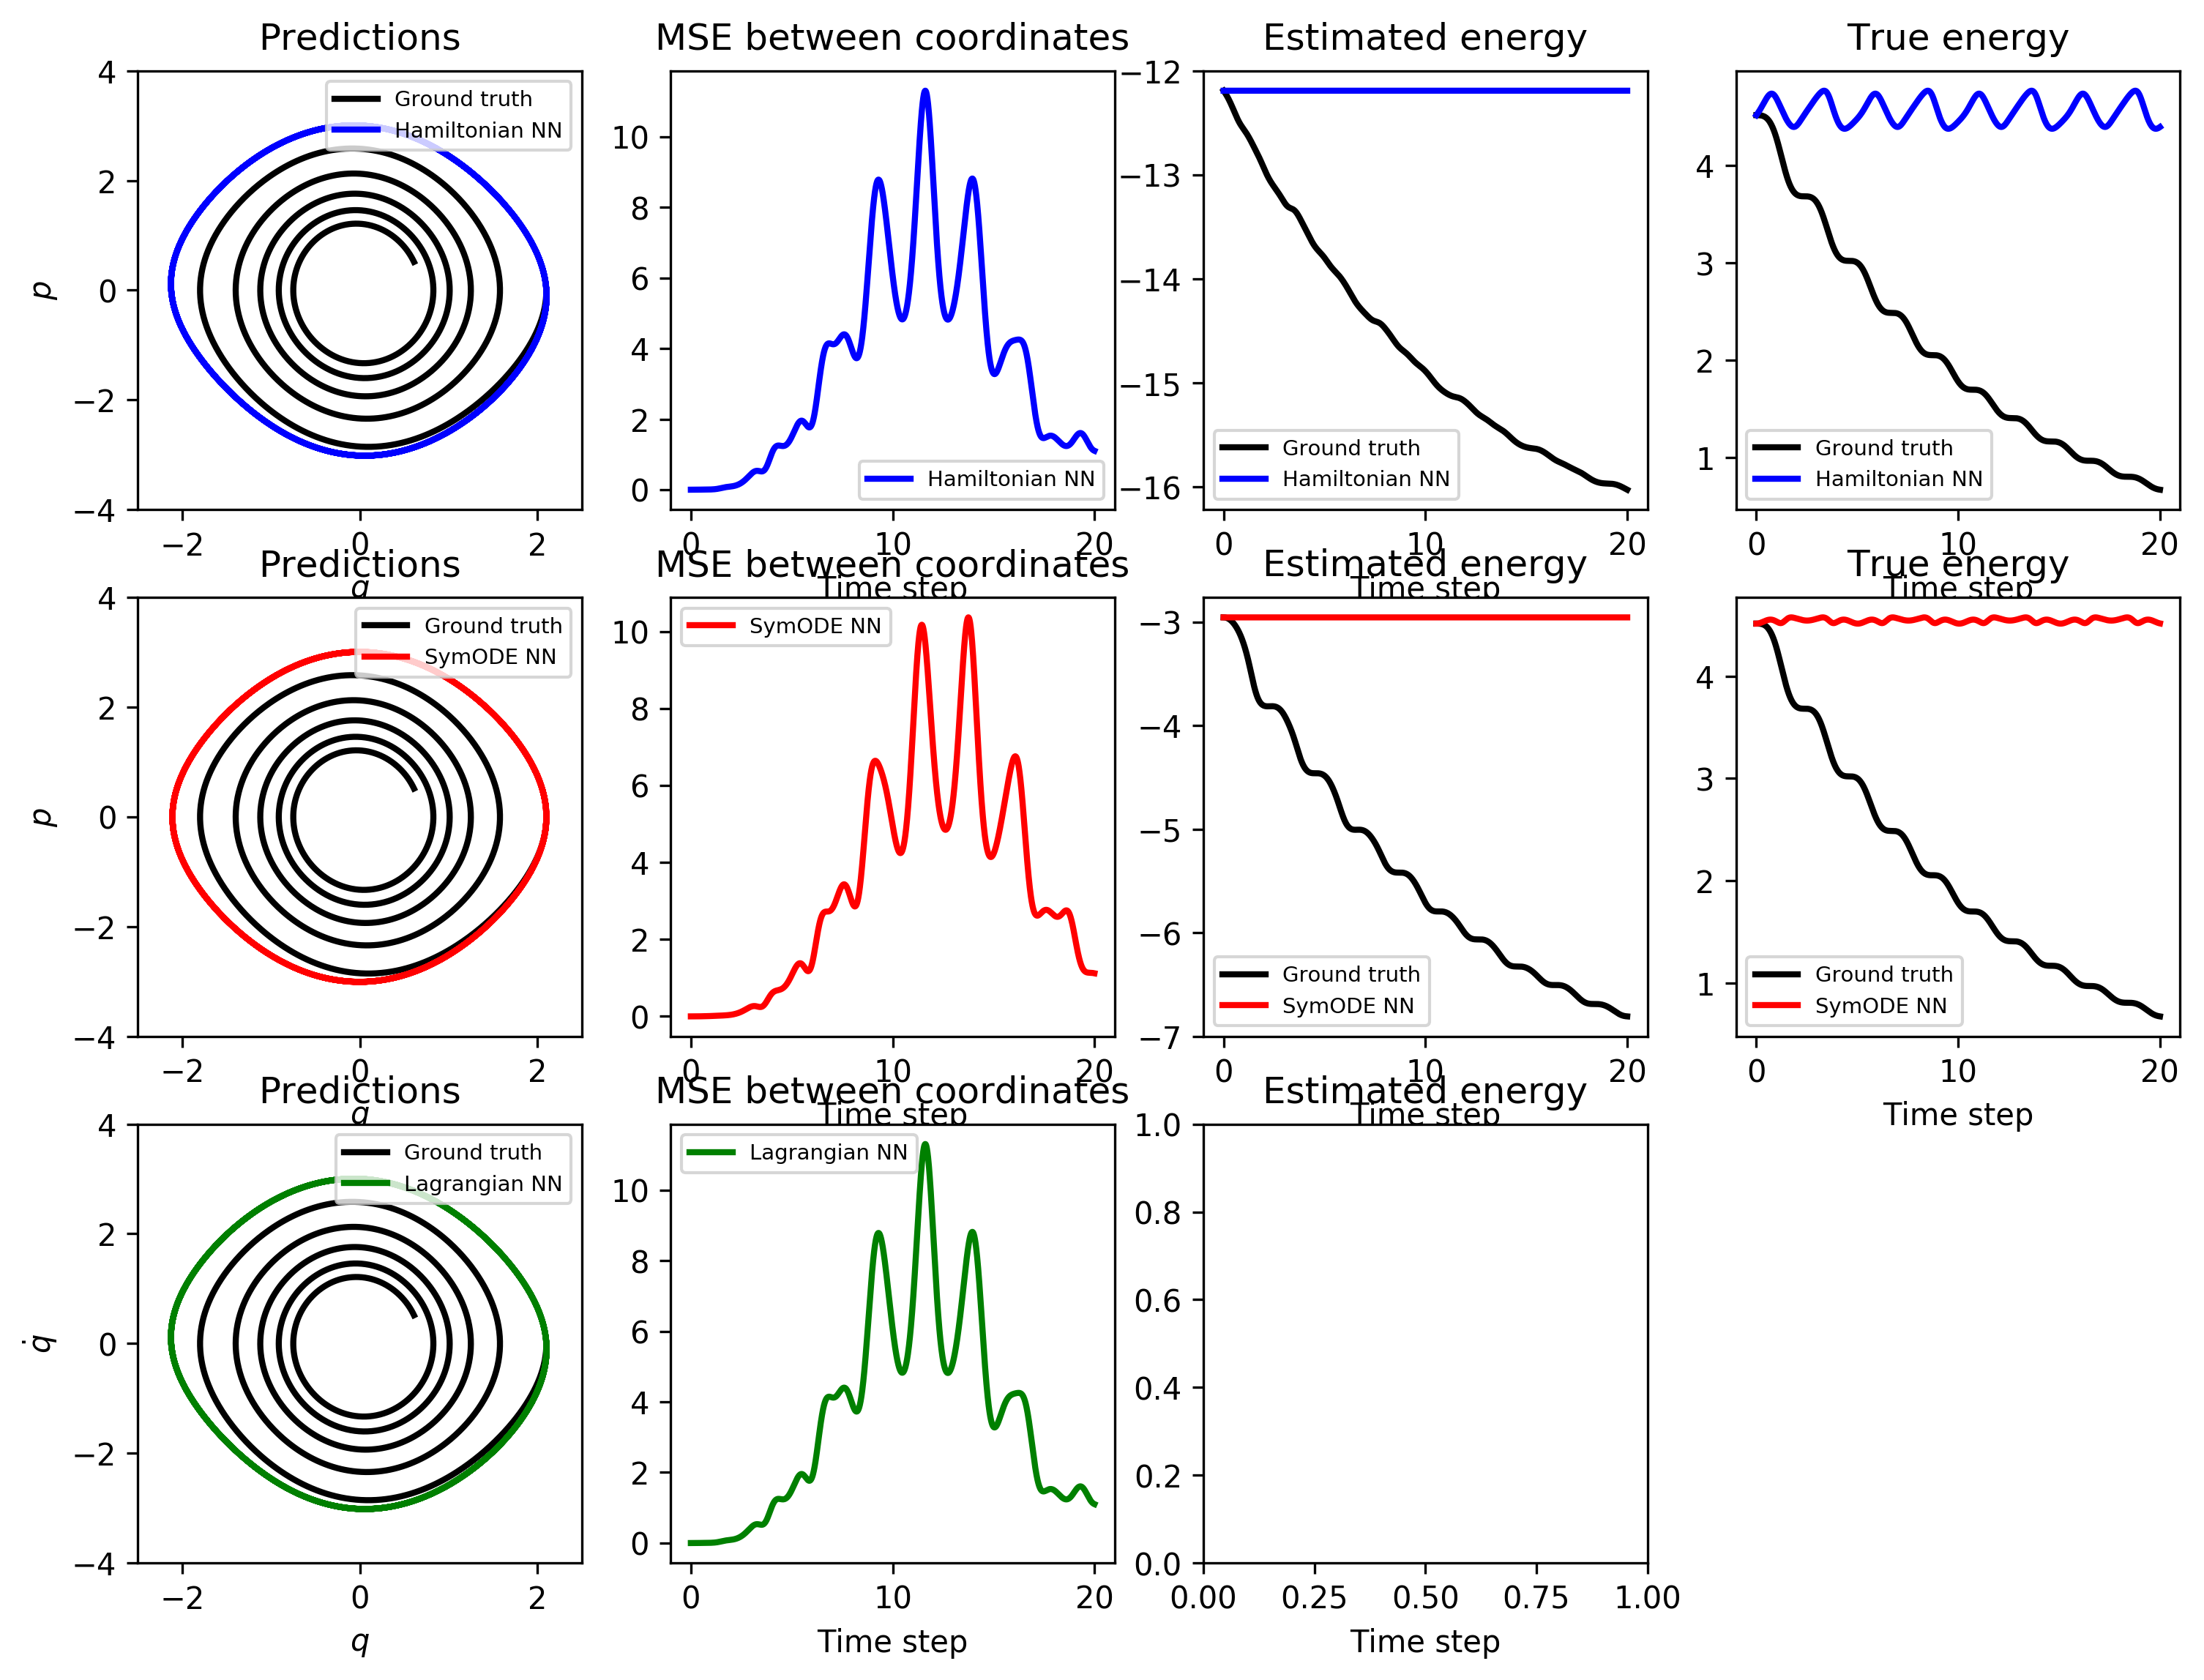

In [10]:
x0 = np.asarray([2.1, 0])

# integration
t_span=[0,20]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
true_x, hnn_x = integrate_models(hnn_model, x0=x0, t_span=t_span, t_eval=t_eval)
_, sym_x = integrate_models(sym_model, x0=x0, t_span=t_span, t_eval=t_eval)
true_lag_x, lag_x = integrate_models(lag_model, x0=x0, t_span=t_span, t_eval=t_eval)

# plotting
tpad = 7

# ham
fig = plt.figure(figsize=[12,9], dpi=DPI)
plt.subplot(3,4,1)
plt.title("Predictions", pad=tpad) ; plt.xlabel('$q$') ; plt.ylabel('$p$')
plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
plt.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=2)
plt.xlim(-2.5,2.5) ; plt.ylim(-4,4)
plt.legend(fontsize=7)

plt.subplot(3,4,2)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(3,4,3)
plt.title("Estimated energy", pad=tpad)
plt.xlabel('Time step')
true_hq = hnn_model(torch.Tensor(true_x))[1].detach().numpy().squeeze()
hnn_hq = hnn_model(torch.Tensor(hnn_x))[1].detach().numpy().squeeze()
plt.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(3,4,4)
plt.title("True energy", pad=tpad)
plt.xlabel('Time step')
true_e = np.stack([hamiltonian_fn(c) for c in true_x])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_x])
plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, hnn_e, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

# sym
plt.subplot(3,4,5)
plt.title("Predictions", pad=tpad) ; plt.xlabel('$q$') ; plt.ylabel('$p$')
plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
plt.plot(sym_x[:,0], sym_x[:,1], 'r-', label='SymODE NN', linewidth=2)
plt.xlim(-2.5,2.5) ; plt.ylim(-4,4)
plt.legend(fontsize=7)

plt.subplot(3,4,6)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_x-sym_x)**2).mean(-1), 'r-', label='SymODE NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(3,4,7)
plt.title("Estimated energy", pad=tpad)
plt.xlabel('Time step')
true_hq = sym_model(torch.Tensor(true_x)).detach().numpy().squeeze()
base_hq = sym_model(torch.Tensor(sym_x)).detach().numpy().squeeze()
plt.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq, 'r-', label='SymODE NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(3,4,8)
plt.title("True energy", pad=tpad)
plt.xlabel('Time step')
base_e = np.stack([hamiltonian_fn(c) for c in sym_x])
plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e, 'r-', label='SymODE NN', linewidth=2)
plt.legend(fontsize=7)

# lag
plt.subplot(3,4,9)
plt.title("Predictions", pad=tpad) ; plt.xlabel('$q$') ; plt.ylabel('$\dot{q}$')
plt.plot(true_lag_x[:,0], true_lag_x[:,1], 'k-', label='Ground truth', linewidth=2)
plt.plot(lag_x[:,0], lag_x[:,1], 'g-', label='Lagrangian NN', linewidth=2)
plt.xlim(-2.5,2.5) ; plt.ylim(-4,4)
plt.legend(fontsize=7)

plt.subplot(3,4,10)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_lag_x-lag_x)**2).mean(-1), 'g-', label='Lagrangian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(3,4,11)
plt.title("Estimated energy", pad=tpad)
plt.xlabel('Time step')
true_lag_hq = lag_model(torch.Tensor(true_lag_x)).detach().numpy().squeeze()
lag_hq = lag_model(torch.Tensor(lag_x)).detach().numpy().squeeze()
plt.plot(t_eval, true_lag_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, lag_hq, 'g-', label='Lagrangian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(3,4,12)
plt.title("True energy", pad=tpad)
plt.xlabel('Time step')
true_lag_e = np.stack([lag_energy_fn(c) for c in true_lag_x])
lag_e = np.stack([lag_energy_fn(c) for c in lag_x])
plt.plot(t_eval, true_lag_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, lag_e, 'g-', label='Lagrangian NN', linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()
fig.savefig('{}/pend-integration{}.{}'.format(args.fig_dir, RK4, FORMAT))

In [ ]:
splits = 5
samples = 3
losses = {'sym_energy' : [], 'hnn_energy' : [], 'lag_energy' : []}
t_eval = np.linspace(t_span[0], t_span[1], 100)

_tmp = [] # for computing batched means
for i in range(splits*samples):
    x0 = np.random.rand(2)*1.6 - .8 # randomly sample a starting px: \in(-2,2) and abs(px) > 0.2
    x0 += 0.2 * np.sign(x0) * np.ones_like(x0)
    true_x, hnn_x = integrate_models(hnn_model, x0=x0, t_span=t_span, t_eval=t_eval)
    _, sym_x = integrate_models(sym_model, x0=x0, t_span=t_span, t_eval=t_eval)
    true_lag_x, lag_x = integrate_models(lag_model, x0=x0, t_span=t_span, t_eval=t_eval)
    
    losses['sym_energy'] += [ energy_loss(true_x, sym_x) ]
    losses['hnn_energy'] += [ energy_loss(true_x, hnn_x) ]
    losses['lag_energy'] += [ energy_loss(true_lag_x, lag_x) ]
    print('{:.2f}% done'.format(100*float(i)/(splits*samples)), end='\r')

In [ ]:
losses = {k: np.array(v) for k,v in losses.items()}
bootstrap_conf = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])/np.sqrt(splits)


print("\nSymODE NN energy MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy MSE: {:.4e} +/- {:.2e}\nLagrangian NN energy MSE: {:.4e} +/- {:.2e}"
      .format(
          np.mean(losses['sym_energy']), bootstrap_conf(losses['sym_energy'], splits),
          np.mean(losses['hnn_energy']), bootstrap_conf(losses['hnn_energy'], splits),
          np.mean(losses['lag_energy']), bootstrap_conf(losses['lag_energy'], splits))
     )